In [32]:
xlsxFilename = 'confidence.xlsx'
path = '/home/bradley/Documents/Research/peak_detect/' + xlsxFilename

# Function declaration 

In [33]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

def groupAnalysis(df, groupName):
    
    df_info = pd.DataFrame(index = df[groupName].unique(), \
                           columns = ['count', 'meanPeakError', 'meanAbsPeakError', \
                                      'peakErrorWithinT', 'stdPeakError', '5%', '95%'])

    df_grouped = df[[groupName] + ['peakErrors_1', 'peakErrorsAbs_1', 'peakErrorsWithinT_1']].groupby(groupName)

    df_info['meanPeakError'] = df_grouped['peakErrors_1'].mean()
    df_info['stdPeakError'] = df_grouped['peakErrors_1'].std()
    df_info['meanAbsPeakError'] = df_grouped['peakErrorsAbs_1'].mean()
    df_info['peakErrorWithinT'] = df_grouped['peakErrorsWithinT_1'].mean()
    df_info['count'] = df_grouped['peakErrors_1'].count()
    df_info['5%'] = df_grouped['peakErrors_1'].quantile(0.05)
    df_info['95%'] = df_grouped['peakErrors_1'].quantile(0.95)

    return df_info.sort_index()

# get the dataframe and do some processing 

In [34]:
df = pd.read_excel(path)

# drop null values 
df = df.dropna()

# remove trailing number on captures 
df['captureNames'] = df['captureNames'].apply(lambda s: re.sub(r'\d+$', '', s))

# define moisture levels in increments 
df['moistureLevel'] = ((df['vwcTrue'] * 2 // 0.1) + 1).astype('int32')
df['moistureLevel'] = df['moistureLevel'].map({1: "0-0.1",\
                                              2: "0-0.1",\
                                              3: "0.1-0.2",\
                                              4: "0.1-0.2",\
                                              5: "0.2-0.25",\
                                              6: "0.25-0.3",\
                                              7: "0.3-0.35",\
                                              8: ">0.35",\
                                              9: ">0.35",\
                                              10: ">0.35"})

# define confidence levels in increments 
df['confidenceLevel'] = (df['confidencePreds_1'] // 0.1).astype('int32')
df['confidenceLevel'] = df['confidenceLevel'].map({0: "0-0.1",\
                                              1: "0.1-0.2",\
                                              2: "0.2-0.3",\
                                              3: "0.3-0.4",\
                                              4: "0.4-0.5",\
                                              5: "0.5-0.6",\
                                              6: "0.6-0.7",\
                                              7: "0.7-0.8",\
                                              8: "0.8-0.9",\
                                              9: "0.9-1"})

# calculate absolute value of peak error 
df['peakErrorsAbs_1'] = abs(df['peakErrors_1'])


# define whether the experiment was active or passive 
df['tagType'] = df['expNames'].apply(lambda x: 'passive' if ('passive' in x) else 'active')

# determine if auto peak within t bins of manual peak 
t = 15
df['peakErrorsWithinT_1'] = np.where(df['peakErrors_1'].abs() <= t, True, False)

print(df.columns)

Index(['expNames', 'captureNames', 'peaksManual', 'peakPreds_1', 'peakPreds_2',
       'peakErrors_1', 'peakErrors_2', 'confidencePreds_1',
       'confidencePreds_2', 'vwcTrue', 'vwcManual', 'vwcPreds_1', 'vwcPreds_2',
       'vwcErrors_1', 'vwcErrors_2', 'moistureLevel', 'confidenceLevel',
       'peakErrorsAbs_1', 'tagType', 'peakErrorsWithinT_1'],
      dtype='object')


# How close are we to the correct bin, on average? 

mean, std for error on bin prediction for template 1 = -6.4877622377622375, 27.883416889452235

Roughly 5% of bin predictions are more than than 63.0 below the measured bin
Roughly 5% of bin predictions are more than than 23.0 above the measured bin


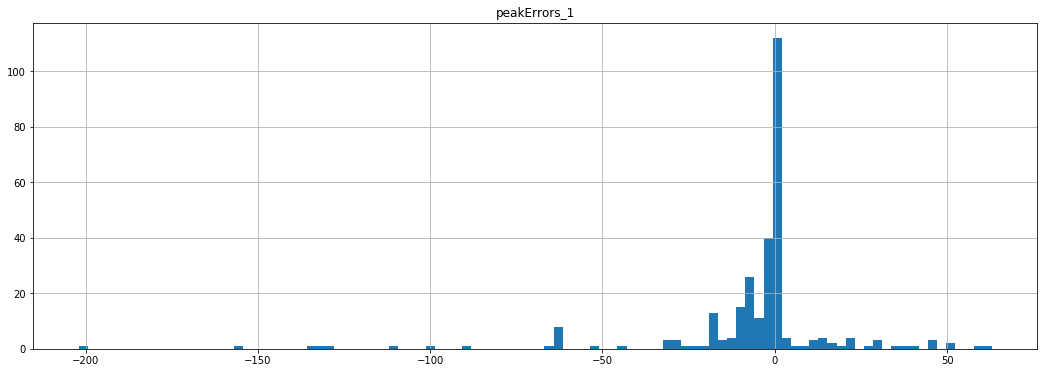

In [35]:
print('mean, std for error on bin prediction for template 1 = {}, {}\n'\
      .format(df['peakErrors_1'].mean(),df['peakErrors_1'].std()))

hist = df.hist(column = 'peakErrors_1', bins = 100, figsize = (18,6));

# 5% and 95% 
print('Roughly 5% of bin predictions are more than than {} below the measured bin'\
      .format(-1*df['peakErrors_1'].quantile(.05).round(0)))
print('Roughly 5% of bin predictions are more than than {} above the measured bin'\
      .format(df['peakErrors_1'].quantile(.95).round(0)))

# Group Analysis

In [36]:
# Analysis by Moisture Level

print(groupAnalysis(df, 'moistureLevel'))

          count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
0-0.1        50      -0.120000          0.280000          1.000000   
0.1-0.2     120      -3.150000          3.933333          0.908333   
0.2-0.25     19      13.763158         21.605263          0.578947   
0.25-0.3     49      -4.693878         24.244898          0.612245   
0.3-0.35     29     -31.586207         32.206897          0.413793   
>0.35        19     -30.894737         30.894737          0.578947   

          stdPeakError     5%   95%  
0-0.1         0.520596   -1.0   1.0  
0.1-0.2       6.113286  -18.0   1.0  
0.2-0.25     25.096684  -10.1  47.2  
0.25-0.3     44.311964  -95.6  43.0  
0.3-0.35     30.877080  -64.6   1.2  
>0.35        49.407483 -136.1   0.0  


In [37]:
# Analysis by experiment 

print(groupAnalysis(df, 'expNames'))

              count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
active_silt      50      -3.320000          3.400000          0.980000   
clay_active      49     -16.693878         17.306122          0.673469   
clay_passive     49       5.612245         10.918367          0.775510   
farm_active      39     -21.500000         21.500000          0.538462   
farm_passive     50      -6.000000         11.800000          0.840000   
silt_passive     49      -0.163265         12.734694          0.816327   

              stdPeakError      5%   95%  
active_silt       9.782200  -11.00   0.0  
clay_active      27.931616  -63.00   2.6  
clay_passive     18.149628   -8.80  45.6  
farm_active      35.452897 -132.20   0.0  
farm_passive     27.551066  -55.25  25.2  
silt_passive     33.892199   -9.00  43.0  


In [38]:
# Analysis by tag

print(groupAnalysis(df, 'tagType'))

         count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
active     138     -13.206522         13.452899          0.746377   
passive    148      -0.222973         11.817568          0.810811   

         stdPeakError     5%    95%  
active      26.754543 -63.00   0.00  
passive     27.538426 -13.65  39.65  


In [39]:
# Analysis by confidence level (1st template)

print(groupAnalysis(df, 'confidenceLevel'))

         count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
0-0.1        9    -123.666667        123.666667          0.000000   
0.1-0.2     21     -21.190476         23.095238          0.666667   
0.2-0.3      3     -10.666667         30.666667          0.333333   
0.3-0.4      7      -8.714286         15.000000          0.571429   
0.4-0.5     15      -0.400000          9.200000          0.800000   
0.5-0.6      1     -28.000000         28.000000          0.000000   
0.6-0.7      3      10.333333         19.666667          0.666667   
0.7-0.8      7      -4.857143          4.857143          1.000000   
0.9-1      220      -0.761364          7.052273          0.831818   

         stdPeakError     5%   95%  
0-0.1       40.221263 -183.2 -73.4  
0.1-0.2     30.805225  -64.0   3.0  
0.2-0.3     44.859038  -54.9  19.8  
0.3-0.4     16.977576  -28.0  11.4  
0.4-0.5     17.859771  -27.8  19.5  
0.5-0.6           NaN  -28.0 -28.0  
0.6-0.7     30.287511  -10.2  40.2  
0.7-0.8      

## Confidence Metric

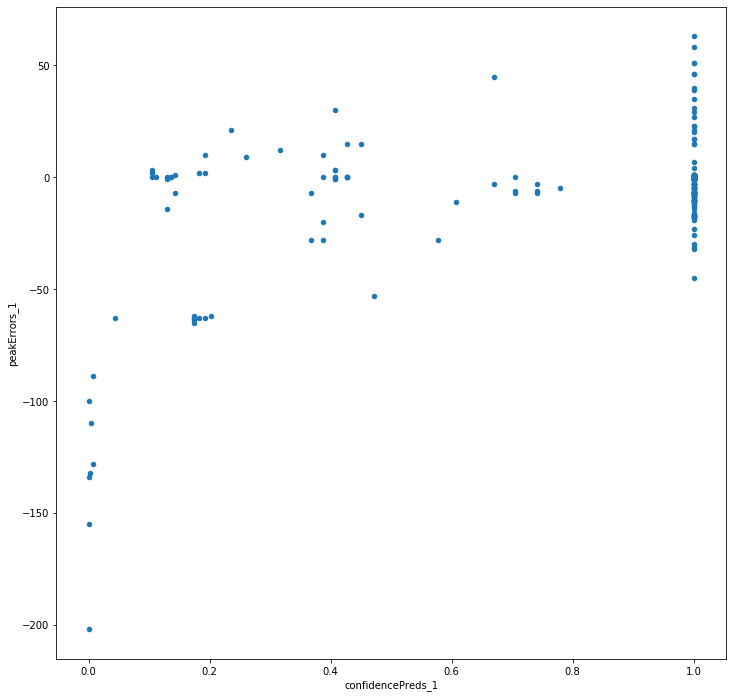

In [40]:
df.plot(kind = 'scatter', x = 'confidencePreds_1', y = 'peakErrors_1', figsize = (12,12))